<a href="https://colab.research.google.com/github/m34ymg/susten-general/blob/master/high_water_mark_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# High Water Mark / Monte Carlo simulation

In [0]:
import pandas as pd
import numpy as np



# Parameter Settings
Here we specify all the parameters required for the MC simulation. 

Initially, we assume:
 - 6% expected return
 - 10% volatility 
 - 10% performance fee over the high-water-mark
 
 
 and run for over the next 10 years, which is 120 months, then repeat it 10,000 times (=num_paths)

In [0]:


avg = .06  #@param {type:"number"}
std_dev = .10  #@param {type:"number"}
perf_fee_rate = .10 #@param {type:"number"}
ann_fact = 12 #@param {type:"integer"}
num_of_years = 10 #@param {type:"integer"}
num_reps = ann_fact * num_of_years
num_paths = 10000 #@param {type:"integer"}


# Simulate one path for given set of params

In [0]:
def simulate_one_path(avg,std_dev,perf_fee_rate,ann_fact,num_of_years):
  returns = np.random.normal(avg / ann_fact, std_dev / np.sqrt(ann_fact), num_reps)


  df = pd.DataFrame(index=range(num_reps), data={'returns_gross_of_fee': returns})
  df['index_gross_of_fee'] = df['returns_gross_of_fee'].add(1).cumprod()
  df['hwm_gross_of_fee'] = df['index_gross_of_fee'].expanding().max()
  
  df['perf_fee_dollar'] = df['returns_gross_of_fee']
  df['perf_fee_dollar'].values[:] = 0

  df['perf_fee_rate'] = df['returns_gross_of_fee']
  df['perf_fee_rate'].values[:] = 0
  
  df['returns_net_of_fee'] = df['returns_gross_of_fee']
  df['index_net_of_fee'] = df['returns_gross_of_fee']
  df['hwm_net_of_fee'] = df['hwm_gross_of_fee']



  cur_hwm = 1.0
  cur_index_net_of_fee = 1.0



  for index, row in df.iterrows():
    new_index = cur_index_net_of_fee * (1 + row['returns_gross_of_fee'])
    row['index_net_of_fee'] = new_index


    if new_index > cur_hwm:
      fee = (new_index - cur_hwm) * perf_fee_rate
      #print(index)
      row['perf_fee_dollar'] = fee
      row['perf_fee_rate'] = fee / new_index
      row['index_net_of_fee'] = new_index - fee
      row['returns_net_of_fee'] = row['index_net_of_fee'] / cur_index_net_of_fee - 1
      cur_hwm = row['index_net_of_fee']

    row['hwm_net_of_fee'] = cur_hwm
    cur_index_net_of_fee = row['index_net_of_fee']


  df['cum_fee'] = df['perf_fee_dollar'].cumsum()
  
  return df


# Extract key outputs for given 'df'

In [0]:

def extract_result(df, ann_fact, num_reps):

  res = df.tail(1)

  avg_net_of_fee = res['index_net_of_fee']**( ann_fact / num_reps ) - 1
  avg_gross_of_fee = res['index_gross_of_fee']**( ann_fact / num_reps ) - 1

  std_dev_gross_of_fee = df['returns_gross_of_fee'].std() * np.sqrt(ann_fact)
  std_dev_net_of_fee = df['returns_net_of_fee'].std() * np.sqrt(ann_fact)

  Sharpe_net_of_fee = avg_net_of_fee / std_dev_net_of_fee
  Sharpe_gross_of_fee = avg_gross_of_fee / std_dev_gross_of_fee
  
  avg_perf_fee_rate = df['perf_fee_rate'].mean() * ann_fact

  return ({
      'avg_net_of_fee' : avg_net_of_fee.values[0],
      'avg_gross_of_fee' : avg_gross_of_fee.values[0],
      'std_dev_gross_of_fee':std_dev_gross_of_fee,
      'std_dev_net_of_fee':std_dev_net_of_fee,
      'Sharpe_net_of_fee': Sharpe_net_of_fee.values[0],
      'Sharpe_gross_of_fee': Sharpe_gross_of_fee.values[0],
      'avg_perf_fee_rate': avg_perf_fee_rate,
  })



# Run simulation 
This when it gets super slow.. (depending on the num_of_paths params)

In [0]:
all_res = []

for i in range(0, num_paths):

  df = simulate_one_path(avg,std_dev,perf_fee_rate,ann_fact,num_of_years)
  res = extract_result(df, ann_fact, num_reps)
  all_res.append(res)
  
  
res_df = pd.DataFrame(all_res)


# Now.. let's see how it goes..

Obviously, the distribution gets positively skewed.

0.23173102803363116

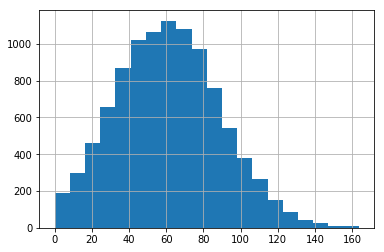

In [175]:
res_df['avg_perf_fee_rate'].mul(10000).hist(bins=20)
res_df['avg_perf_fee_rate'].skew()

..but the mean/median seem to be not that different from 60bps (=6% ex-ante times 10% p.f.). Isn't it surprising!?

In [174]:
res_df['avg_perf_fee_rate'].mul(10000).describe()

count    10000.000000
mean        61.164104
std         27.728068
min          0.000000
25%         41.205501
50%         60.552888
75%         79.734808
max        163.617256
Name: avg_perf_fee_rate, dtype: float64

# Debug section

In [154]:
  df = simulate_one_path(avg,std_dev,perf_fee_rate,ann_fact,num_of_years)
  df

,returns_gross_of_fee,index_gross_of_fee,hwm_gross_of_fee,perf_fee_dollar,perf_fee_rate,returns_net_of_fee,index_net_of_fee,hwm_net_of_fee,cum_fee
0,0.022689,1.022689,1.022689,0.002269,0.002219,0.020420,1.020420,1.020420,0.002269
1,-0.004474,1.018114,1.022689,0.000000,0.000000,-0.004474,1.015855,1.020420,0.002269
2,0.045379,1.064315,1.064315,0.004153,0.003911,0.041290,1.057800,1.057800,0.006422
3,-0.013452,1.049997,1.064315,0.000000,0.000000,-0.013452,1.043570,1.057800,0.006422
4,0.081258,1.135318,1.135318,0.007057,0.006254,0.074496,1.121312,1.121312,0.013479
5,-0.014204,1.119192,1.135318,0.000000,0.000000,-0.014204,1.105385,1.121312,0.013479
6,-0.010217,1.107757,1.135318,0.000000,0.000000,-0.010217,1.094091,1.121312,0.013479
7,0.002312,1.110318,1.135318,0.000000,0.000000,0.002312,1.096620,1.121312,0.013479
8,-0.027874,1.079369,1.135318,0.000000,0.000000,-0.027874,1.066054,1.121312,0.013479
9,0.014728,1.095267,1.135318,0.000000,0.000000,0.014728,1.081755,1.121312,0.013479


In [0]:
from google.colab import files

df.to_csv('df.csv')
files.download('df.csv')

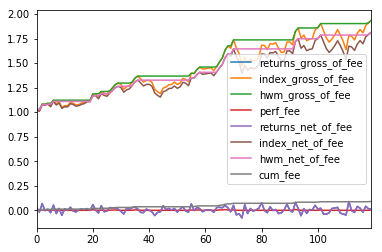

In [110]:
df.plot()